## Abstract

In this blog post, we implement logistic regression via empirical risk minimization and perform a few experiments to highlight the model's strengths and weaknesses.
As a part of our experimentation, we implement gradient descent with momentum and investigate the evolution of our loss function in comparison to ordinary gradient descent.
We also test our model on data with more dimensions than observations in order to illustrate the perils of overfitting.
To see my implementation of logistic regression, please visit [`logistic.py`](logistic.py).

## Generating Training Data

First, we import the packages we will need for this assignment.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

Next, we generate the data that we will use to train our model.
Thank you to Professor Chodrow for providing the functions for generating and visualizing training data.

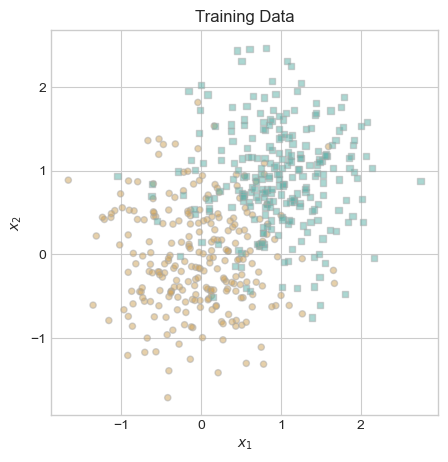

In [2]:
# Define function to generate data
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

# define function to plot data
def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -0.5, vmax = 1.5, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# set seed
torch.manual_seed(1234)

# generate data
X, y = classification_data(n_points = 500, noise = 0.6)

# plot data
fig, ax = plt.subplots(figsize = (5, 5))
plot_data(X, y, ax)
ax.set_title("Training Data");

## Vanilla Gradient Descent

To begin evaluating the efficacy of our model, we fit logistic regression on our training data with regular gradient descent.
We actually only implemented gradient descent with momentum in [`logistic.py`](logistic.py), but if we set $\beta = 0$, as we do below, this is equivalent to regular gradient descent.

In [3]:
# set seed
torch.manual_seed(1234)

# initialize logistic regression model and optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize vector to record loss values
loss_vec_vanilla = []

# fit model
while len(loss_vec_vanilla) < 2 or loss_vec_vanilla[-2] - loss_vec_vanilla[-1] > 0.00001:

    # update model
    opt.step(X, y, alpha = 0.07, beta = 0)

    # calculate and record loss
    loss = LR.loss(X, y) 
    loss_vec_vanilla.append(loss)

Now that we have fit our model, let's inspect our decision boundary in the context of our training data.

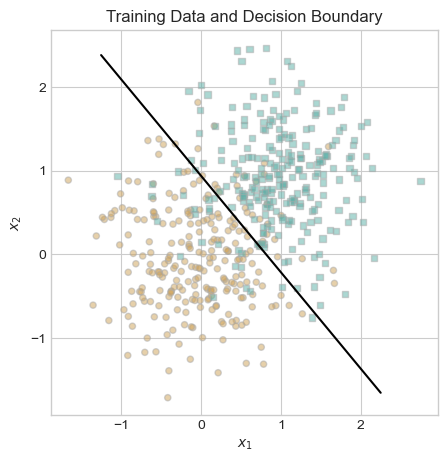

In [4]:
# define function to draw line
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

# plot decision boundary
fig, ax = plt.subplots(figsize = (5, 5))
plot_data(X, y, ax)
draw_line(LR.w, x_min = -1.25, x_max = 2.25, ax = ax, color = "black")
ax.set_title("Training Data and Decision Boundary");

Visually, this line appears to be an intelligent choice.
There are some misclassified points on either side of the line, but our data is not linearly separable, so it is impossible to correctly classify all points using a linear decision boundary.
This visual check leads me to believe that our classifier is performing well.
As another check, we plot the evolution of our loss function below to verify that it decreases monotonically.

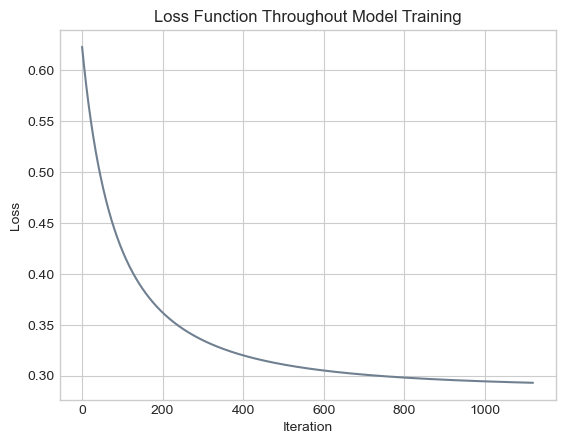

In [5]:
# plot the changes in loss 
plt.plot(loss_vec_vanilla, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training");

In this graph, every iteration has a lower loss value than the iteration that precedes it.
In other words, our loss function decreases monotonically, as guaranteed by gradient descent.

### The Benefits of Momentum

Our model appears to be behaving as expected, leading us to the natural question: can we do better if we use gradient descent with momentum?
More specifically, can the model converge to an appropriate weight vector in fewer iterations under gradient descent with momentum?
To address this question, we fit a logistic regression model using the same values for $\alpha$ and our random seed, but with the modification that $\beta = 0.9$ rather than $0$.

In [6]:
# set seed
torch.manual_seed(1234)

# initialize logistic regression model and optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize vector to record loss values
loss_vec_momentum = []

# fit model
while len(loss_vec_momentum) < 2 or loss_vec_momentum[-2] - loss_vec_momentum[-1] > 0.00001:

    # update model
    opt.step(X, y, alpha = 0.07, beta = 0.9)

    # calculate and record loss
    loss = LR.loss(X, y) 
    loss_vec_momentum.append(loss)

To identify any improvements due to gradient descent with momentum, we plot the evolution of the loss function under both scenarios on the same graph.

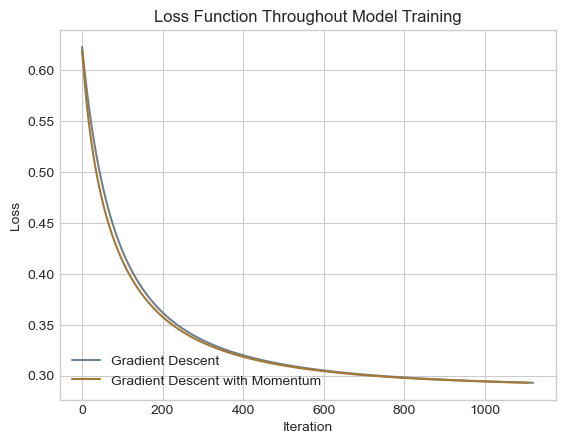

In [7]:
# plot the changes in loss 
plt.plot(loss_vec_vanilla, color = "slategrey", label = "Gradient Descent")
plt.plot(loss_vec_momentum, color = "#A37933", label = "Gradient Descent with Momentum")
labs = plt.gca().set(xlabel = "Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training")
plt.legend(loc = "lower left");

In this scenario, the loss function of gradient descent with momentum decreased slightly more rapidly than regular gradient descent.
To be fully transparent, producing a scenario with this improvement involved some fishing for appropriate data and $\alpha$.
In this case, gradient descent with momentum performed slightly better than regular gradient descent, but this is by no means a guarantee.

### The Perils of Overfitting

In this section, we construct a scenario where logistic regression overfits to the training data.
To accomplish this task, we fit a model on data with substantially more dimensions than observations.
Specifically, we generate training data and test data which both contain 30 dimensions and 20 observations, using a function for generating classification data generously provided by Professor Chodrow.
Then we fit our logistic regression model on our training data, resulting in the evolution of our loss function as illustrated below.

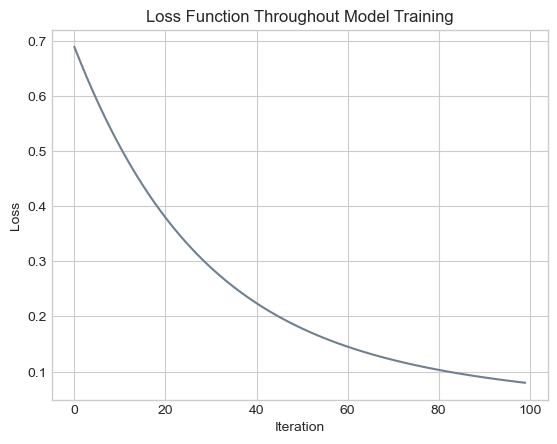

In [8]:
# set seed
torch.manual_seed(1234)

# generate data
X_train, y_train = classification_data(n_points = 20, noise = 0.5, p_dims = 30)
X_test, y_test = classification_data(n_points = 20, noise = 0.5, p_dims = 30)

# initialize logistic regression model and optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize vector to record loss values
loss_vec_overfit = []

# fit model
for _ in range(100):

    # update model
    opt.step(X_train, y_train, alpha = 0.1, beta = 0.9)

    # calculate and record loss
    loss = LR.loss(X_train, y_train) 
    loss_vec_overfit.append(loss)
    if loss == 0:
        break

# plot the changes in loss 
plt.plot(loss_vec_overfit, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training");

In this figure, we find that our loss function decreased in the same monotonic manner as before, converging to a decision boundary with a loss value of less than 0.1.
Below, we calculate the training accuracy of our model.

In [9]:
# Compute training accuracy
y_hat = LR.predict(X_train)
train_accuracy = (1.0*(y_hat == y_train)).mean().item()
train_accuracy

1.0

At 100% training accuracy, our model is correctly predicting the outcome variable of every observation in our training data.
But what about testing accuracy?

In [10]:
# Compute testing accuracy
y_hat = LR.predict(X_test)
test_accuracy = (1.0*(y_hat == y_test)).mean().item()
test_accuracy

0.6499999761581421

At roughly 65%, our testing accuracy is not nearly as high as our training accuracy.
Our model appears to have been overfit to our training data, failing to generalize to test data that was generated in a similar manner.
Why might this have happened?

I suspect that 20 observations of training points is simply insufficient for training a model in 30 dimensional space.
There are so many possibilities for where a point can be located in 30 dimensional space, and 20 observations barely scratches the surface of these possibilities.
Our model would need substantially more training data in order to have been exposed to enough of these possibilities.
In the absence of sufficient training data, our model reflects the noise of our training data rather than the underlying pattern.

## Conclusion

In this assignment, we implemented logistic regression via empirical risk minimization within the object-oriented framework provided by Professor Chodrow.
We investigated the differences between regular gradient descent and gradient descent with momentum, discovering that the latter option converges to a solution more rapidly in some cases.
We also illustrated that logistic regression tends to overfit when the training data has more dimensions than observations.
Implementing logistic regression and experimenting with the model's parameters furthered my understanding of logistic regression in particular and gradient descent more broadly.